In [1]:
import json
import pandas as pd
import numpy as np
from numpy import inf
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance
import time
import random
from glob import glob
from sklearn.metrics import classification_report, average_precision_score
from sklearn.model_selection import train_test_split
import os
from preprocess import Preprocess

In [2]:
class SEARCH_RECOMMEND:
    
    def __init__(self, df, qval=None, style_ths=0.1):

        self.style_ths_str = str(style_ths)[-1]
        self.df = df
        self.qval = qval  # Q-Value : 거리 유사도 알고리즘에서 q-gram 으로 문장을 어떻게 나눌지 결정하는 파라미터 (None:단어기반, 1:철자기반, 2~more:q-gram)
        self.df_ = self.preprocess_df(self.df)  # new_tag feature를 새롭게 추가 전처리
        self.user_item_set = set()  # 사용자가 아이템을 선택(검색/추천)시 => 사용자가 선택한 아이템 목록
        self.user_item_len = 0
        self.cold_start = True   # Cold Start : 최적화된 추천 알고리즘 선택을 위해 사용자의 아이템 목록이 비어있는지 확인하는 변수
        
    def preprocess_df(self, df):
        """
        # make new-tag
        # top3_style, tags, name, projectId 를 하나의 string으로 만들기
        """
        
        proj_ids = df.groupby('product_id')['projectId'].agg(lambda x: list(set(x))).reset_index().rename(columns={'projectId':'project_ids'})
        products_df = df.sort_values(by='awesome_score', ascending=False).drop_duplicates('product_id').reset_index(drop=True)
        products_df = products_df.join(proj_ids.set_index('product_id'), on='product_id')
        products_df['project_ids_str'] = products_df['project_ids'].apply(lambda x: ' '.join(x))
        products_df['weighed_project_id'] = (products_df.projectId.apply(lambda x : x+' ') * products_df.top_score.apply(lambda x : int(x*10))).tolist()
        products_df['weighed_style'] = (products_df.top_style.apply(lambda x : x+' ') * products_df.top_score.apply(lambda x : int(x*10))).tolist()
        products_df['new_tag'] = list(
                            zip(
                                products_df[f'top_style_{self.style_ths_str}'].tolist(), 
                                products_df['weighed_style'].tolist(), 
                                products_df['tags'].apply(lambda x: random.sample(x, int(len(x)*0.2))).tolist(),
                                products_df['weighed_project_id'].tolist(),
                                products_df['project_ids_str'].tolist(),
                                )
                            )
        products_df['new_tag'] = products_df['new_tag'].apply(self.reduce_newtag)
        products_df['new_tag'] = products_df['new_tag'].apply(lambda x: ' '.join(x))

        return products_df
    
    def reduce_newtag(self, x):
        newtag = []
        for tag in x:
            if type(tag) == str:
                newtag.append(tag)
            else:
                newtag.extend(tag)
        return newtag
    
    def add_item_in_user_item_set(self, prod, verbose=True):
        """
        # 사용자 셋에 아이템 추가
        """
        prev_len = len(self.user_item_set)
        if verbose:
            print(f'사용자 님의 아이템 목록에 [{prod}]를 추가합니다.')
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
        cat_ = self.df_[self.df_['name'] == prod]['category'].values[0]
        self.user_item_set.add((id_, cat_))
        self.cold_start = False
        if verbose:
            print(f'사용자 님이 현재 선택한 아이템 목록 : {self.user_item_set}')
        if len(self.user_item_set) > prev_len:
            self.user_item_len += 1
        return id_
    
    def remove_item_from_user_item_set(self, prod, verbose=True):
        """
        # 사용자 셋에서 아이템 제거
        """
        prev_len = len(self.user_item_set)
        if verbose:
            print(f'사용자 님의 아이템 목록에서 [{prod}]를 제거합니다.')
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
        cat_ = self.df_[self.df_['name'] == prod]['category'].values[0]
        self.user_item_set.remove((id_, cat_))
        if verbose:
            print(f'사용자 님의 현재 남아있는 선택된 아이템 목록 : {self.user_item_set}')
        # 사용자 목록이 비게 되면 콜드스타트
        if len(self.user_item_set) > 1:
            self.cold_start = True
        if len(self.user_item_set) < prev_len:
            self.user_item_len -= 1
            
    def get_similarity_score(self, search_prod_tag, algo='sorensen', verbose=True):
        """
        # 사용자가 선택한 아이템과 데이터 내 모든 아이템들과의 유사도 계산
        
        search_prod_tag : string, 사용자가 선택한 아이템 이름으로부터 매칭된 self.df_['new_tag'].values
        algo : 'sorensen' - 토큰 기반 거리 유사도 알고리즘, 'ncd' - 문장 압축을 통한 유사도 알고리즘
        """
        sim_score = []
        new_tag = self.df_['new_tag'].tolist()
        start_time = time.time()
        for i, tag in enumerate(new_tag):
            if algo == 'sorensen':
                sim_score.append(textdistance.Sorensen(qval=self.qval, as_set=False).normalized_similarity(search_prod_tag, tag))
            elif algo == 'ncd':
                sim_score.append(textdistance.EntropyNCD(qval=self.qval).normalized_similarity(search_prod_tag, tag))
        if verbose:
            print(f'검색 태그 : {search_prod_tag}')
            print(f'검색 시간 : {round(time.time()-start_time, 4)}초\t검색 알고리즘 : {algo}')
            print()
        return sim_score
    
    def search_product(self, 
                       prod, 
                       topn=10, 
                       algo='sorensen', 
                       from_product_id='True', 
                       base_path=None,
                       save_image=True,
                       verbose=True):
        """
        # 사용자 선택한 아이템/아이템 목록으로부터 유사도를 통해 아이템 추천
        
        prod : string, 아이템 이름
        topn : int, 유사도 상위 n개의 아이템 추천
        algo : 'sorensen' - 토큰 기반 거리 유사도 알고리즘, 'ncd' - 문장 압축을 통한 유사도 알고리즘
        from_product_id : boolean, 제품 아이디 기반으로 검색할지에 대한 파라미터
        base_path : string, 추천 결과를 저장할 기본 경로 설정
        """
        
        if from_product_id:
            # 아이템을 사용자 아이템 목록에 추가
            # declare id, category of searching product
            id_ = self.add_item_in_user_item_set(prod, verbose=verbose)
            prod_cat = self.df_[self.df_['product_id'] == id_]['category'].values[0]

            # 사용자가 현재 선택한 아이템이 속해 있는 project_id 가져오기
            self.project_id = self.df_[self.df_['name'] == prod]['project_ids'].values[0]

            if verbose:
                print(f"검색 아이템이 해당한 프로젝트 ID : {self.project_id}")
        
            # 사용자의 정보가 없는 경우 => 단일 아이템에 대한 태그 기반 추천 검색
            if self.cold_start:
                # retrieve the product tag from the input product id
                # 동일 아이템이 여러 전문가에 사용될 경우 => awesome_score 가 더 높은 점수를 받은 아이템의 new_tag를 가져옴
                search_prod_tag = self.df_[self.df_['product_id'] == id_]['new_tag'].values[0]
            # 사용자 아이템 목록이 있는 경우 => 사용자가 이미 배치한 기존 아이템들까지 포함한 복수의 아이템에 대한 태그 기반 추천 검색
            else:
                search_prod_tag = ''
                for existing_item_id, _ in self.user_item_set:
                    temp_id = self.df_[self.df_['product_id'] == existing_item_id]['new_tag'].values[0]
                    search_prod_tag += temp_id+' '
                search_prod_tag = search_prod_tag[:-1]
        
        else:
            search_prod_tag = prod
            
        # 해당 아이템-다른 아이템 간 유사도 계산
        sim_score = self.get_similarity_score(search_prod_tag, algo=algo, verbose=verbose)
        
        # 유사도 결과를 통해 최종 추천 아이템 테이블 만들기
        sim_score = np.asarray(sim_score)  # [사용자가 선택한 아이템-다른 모든 아이템] 간 유사도 점수
        sim_score_idx = np.arange(len(sim_score)) # 유사도 점수에 대한 인덱스
        
        result_df = self.df_.iloc[sim_score_idx][['product_id', 'name', 
                                                  'new_tag', 'project_ids', 
                                                  'images', 'category']]
        result_df['similarity'] = sim_score
        
        # filtering : 정교한 추천 결과를 위한 검색 필터링 추가
        result_df = result_df.drop_duplicates(['product_id'])  # 중복된 아이템 제거
        
        # 사용자가 이미 배치한 아이템 혹은 같은 카테고리의 아이템들은 추천목록에서 제거
        if len(self.user_item_set) >= 1:
            if verbose:
                print("!!사용자가 이미 선택한 아이템, 같은 카테고리 아이템들은 추천목록에서 제거!!")
            for existing_item_id, existing_item_cat in self.user_item_set:
                result_df = result_df[result_df['product_id']!=existing_item_id]
                result_df = result_df[result_df['category']!=existing_item_cat]
                
        # 유사도가 가장 높은 순서대로 정렬 => top-n개 까지 추천 결과 저장
        self.result = result_df.sort_values(by='similarity', ascending=False).reset_index()[:topn] 
        result_df = result_df[result_df['category'] != prod_cat] 
        result_df = result_df.sort_values(by='similarity', ascending=False).reset_index()[:topn] 
        
        # show result image
        print(f'사용자가 선택한 아이템 : {prod}')
        try:
            prod_res = requests.get(self.df_[self.df_['name'] == prod]['images'].values[0][0])
            display(Image.open(BytesIO(prod_res.content)))
        except:
            print('이미지 없음\n')
            print()

        print("="*80)
        print(f"추천 아이템 Top{topn}")
        print("="*80)
        
        i = 1
        for name, img_url in result_df[['name', 'images']].values:
            print(f"추천 {i}순위 : {name}")
            try:
                res = requests.get(img_url[0])
                img = Image.open(BytesIO(res.content))
                display(img)
            except:
                print('이미지 없음\n')
            print("-"*60)
            i += 1
        
        self.result = result_df

In [3]:
base_bath = '2022-03-14/'

# abs path -> 22-03-07/ *.json
best = glob(base_bath+'best*.json')
item = glob(base_bath+'item*.json')
products = glob(base_bath+'products*.json')
#category1 == category2 = True
category = glob(base_bath+'categories.json')

In [4]:
best, item, products, category

(['2022-03-14/bestshots.json'],
 ['2022-03-14/items.json'],
 ['2022-03-14/products.json'],
 ['2022-03-14/categories.json'])

In [5]:
# 데이터전처리 클래스로부터 객체 선언하기
# style_ths = 0.1
# style_ths_str = str(style_ths)[-1]
st = time.time()
DATA = Preprocess(best, item, products, category)
print(f"{time.time()-st}초")

3.551165819168091초


In [6]:
best_item_df, products_df_4, products_df_b = DATA.best_item, DATA.products_4, DATA.products_b
best_item_df.shape, products_df_4.shape, products_df_b.shape

((10855, 39), (10465, 14), (105211, 14))

In [7]:
for item_name in products_df_b.name.tolist():
    if '스탠드' in item_name:
        print(item_name)
        break

[스탠드형] 무풍갤러리에어컨 AF17TX773FZS 17평형 기본설치비(그레이)


In [8]:
# qval=None => 아이템과 유사한 카테고리의 결과 추천 / qval=int => 아이템과 비슷한 스타일의 다른 아이템 추천(기존 전문가 셋을 기반)
search_engine_b = SEARCH_RECOMMEND(products_df_b, qval=None)

[스탠드형] 무풍갤러리에어컨 AF17TX773FZS 17평형 기본설치비(그레이)
사용자 님의 아이템 목록에 [[스탠드형] 무풍갤러리에어컨 AF17TX773FZS 17평형 기본설치비(그레이)]를 추가합니다.
사용자 님이 현재 선택한 아이템 목록 : {('Xr78icj4A312D98A68C4F0E', '가전')}
검색 아이템이 해당한 프로젝트 ID : ['Xz1vFo5628B26BA785E44BA', 'X35VhCeAA552F52EFA545DB', 'X0jTnCE303BA1300AEA46F1', 'X2obsWV112851B24FAE4E4C', 'XxKwlAzD9623FBAF02F4826', 'XvKfx7fB39B0CE9593C4A5B', 'XxmK5odE855E155792247A8', 'XvEDkMV2DD91C1AE1BD48FD', 'X9GON8n640A6D07352F4C36', 'X2PiQzQ3B552CF9691D450D', 'XzU88XSBCE78900A3994C51', 'X6Hl791985F57EA69D74899', 'X0Y-RvR4EB09BA505F9403F', 'X6eMi9vBF9F09546EFE415A', 'Xyd3fUAF8E5CCA826DE4A58', 'Xwnc_Da45BB4C9CF4B14FC2', 'Xu2TONiC8A789789D3A4203', 'X3DTYGXBFA9286E91CB43E9', 'XxgSBtF29B78341FAEC4EA4', 'X6uDq9r2DC4F82BF97F47AB', 'X6R5LyS9915E3E0D6CD42CE', 'XyW7R_LE817829513EE4F54', 'Xu7LmoV2C11C0AE639B4D10', 'X4vj6OHF1F0F6E1AB6F4B03', 'XyJ1QCCF4146D8459414BC6', 'XvyScA94F5A529B41E146B9', 'XvLZPmyAE571CE80B9C490C', 'X1We3PuF61CF21AA581433E', 'X8zE4Ne4F49623DEFD844FD', 'X8xgcs-756F66A9FA7D

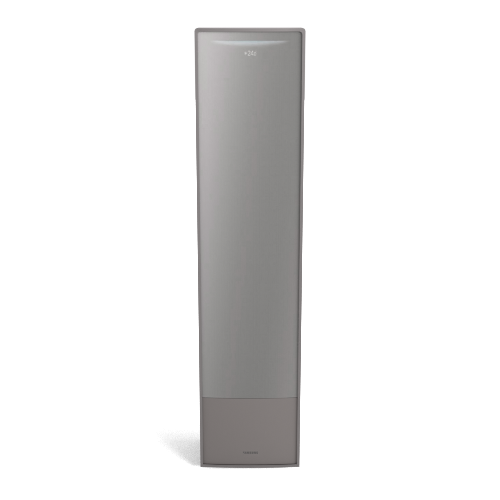

추천 아이템 Top18
추천 1순위 : D2178B. 뷰티레스트 스위트. 슈퍼싱글 침대 (라이트오크)


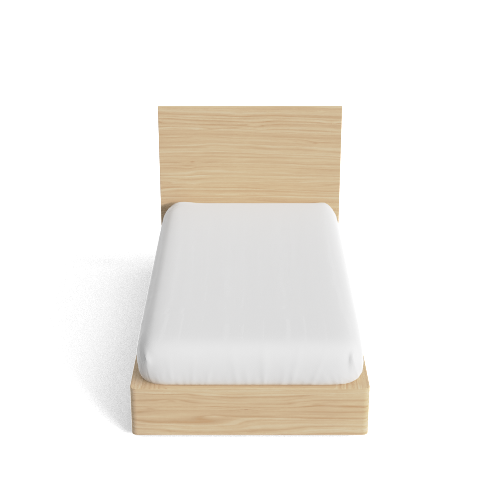

------------------------------------------------------------
추천 2순위 : 라운드 테이블 3colors (화이트-화이트)


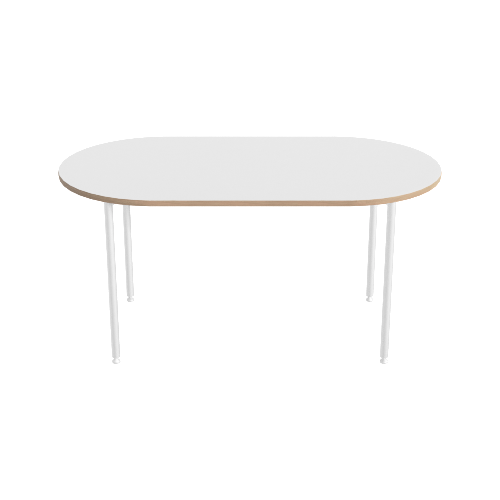

------------------------------------------------------------
추천 3순위 : DSBC082S 800폭 2단 수납형 목제책장 (화이트+화이트)


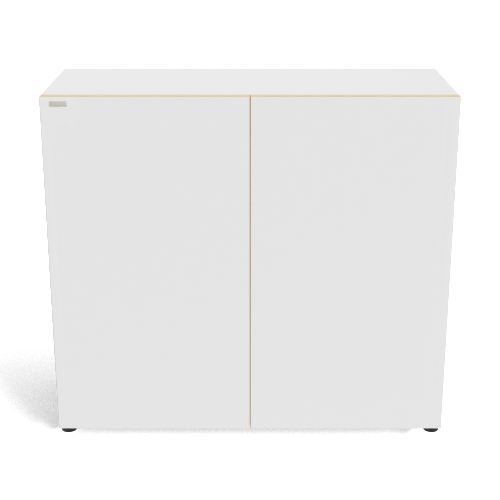

------------------------------------------------------------
추천 4순위 : 시스템000 세트 A-1 (화이트)


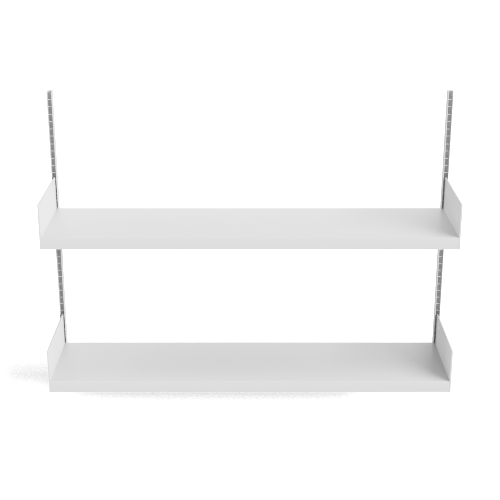

------------------------------------------------------------
추천 5순위 : 타임 인 그레이 3인 소파 Time in grey Sofa 3 (워터소프트 실버)


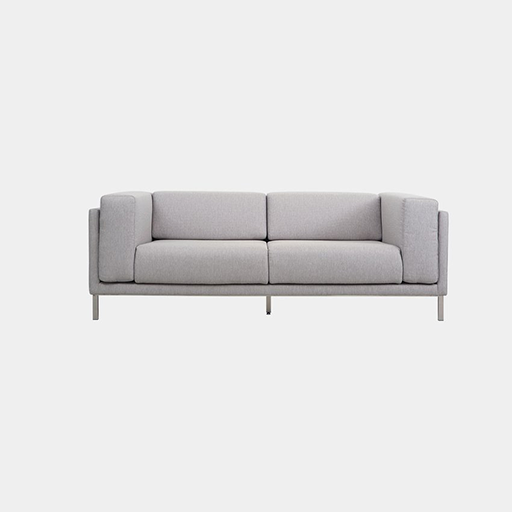

------------------------------------------------------------
추천 6순위 : 키 큰장 (티크)


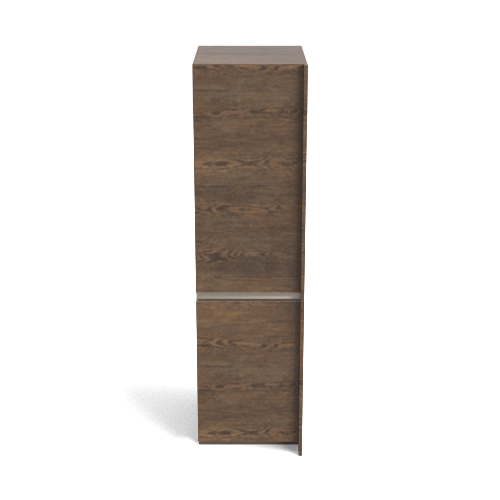

------------------------------------------------------------
추천 7순위 : 싱크대 상부장 (블랙베이지)


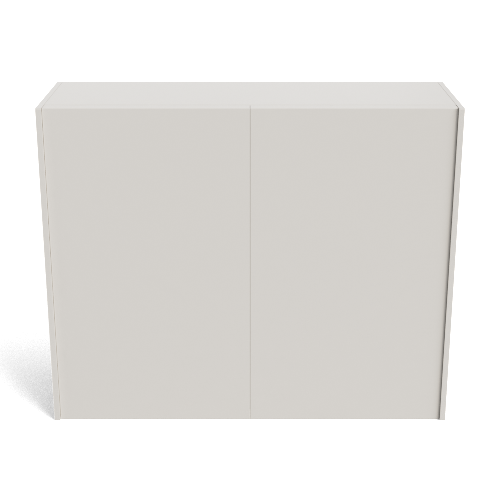

------------------------------------------------------------
추천 8순위 : 시엘바체어 아일랜드식탁 홈바 (그레이)


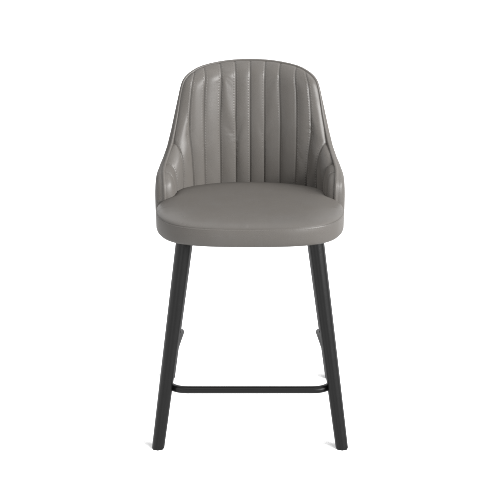

------------------------------------------------------------
추천 9순위 : CAMPANA 단스탠드 E14 KS1823T (블랙)


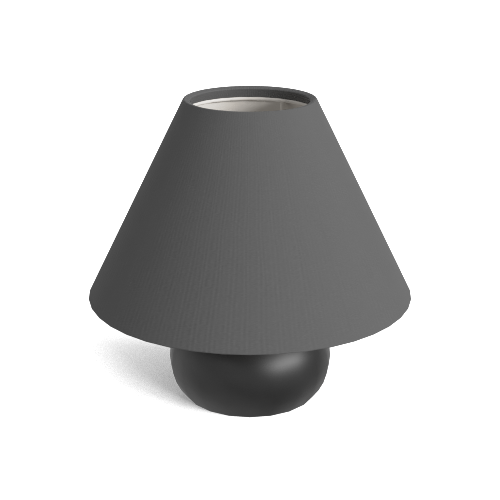

------------------------------------------------------------
추천 10순위 : 모던벤치 카페 다용도 선반 (그레이)


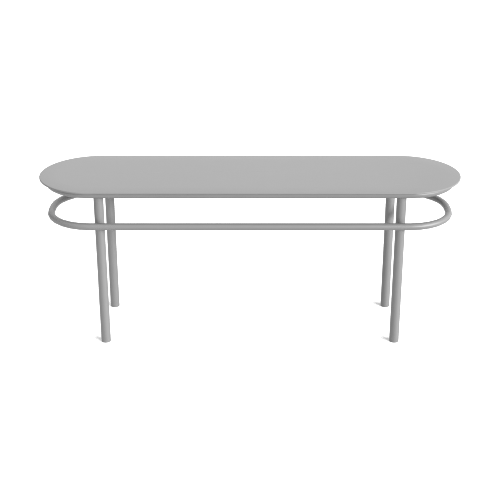

------------------------------------------------------------
추천 11순위 : 로띠끄 대리석 소파 테이블 3colors (높이 37cm) (로즈골드)


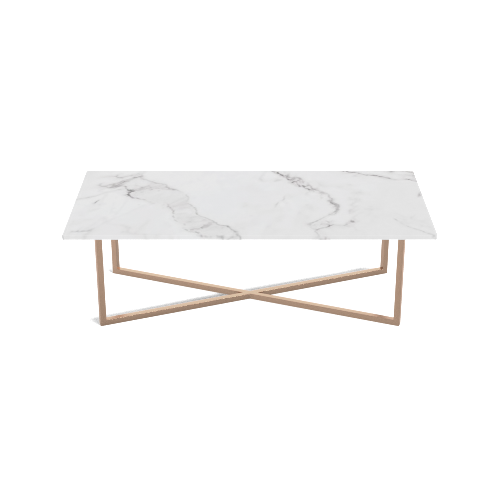

------------------------------------------------------------
추천 12순위 : 노란 추상화 인테리어 캔버스액자 연회 No.004 5070(중대형)


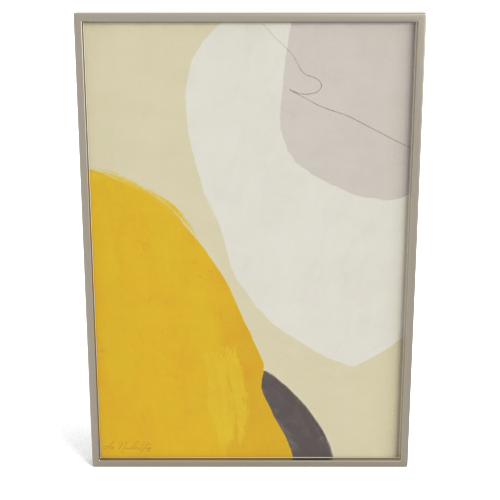

------------------------------------------------------------
추천 13순위 : 비비드 천연면피 스터닝 통가죽 4인소파 (크림베이지)


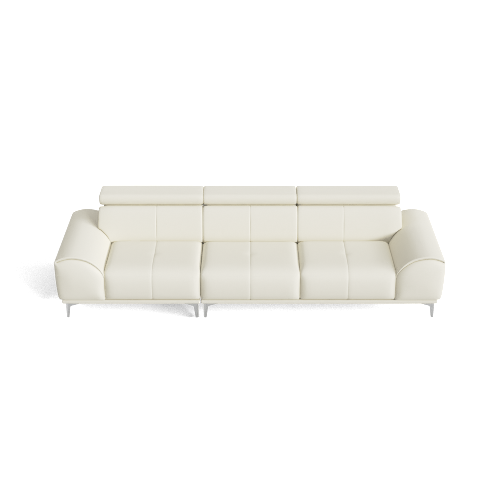

------------------------------------------------------------
추천 14순위 : KURBY 의자 3colors ( 내추럴 )


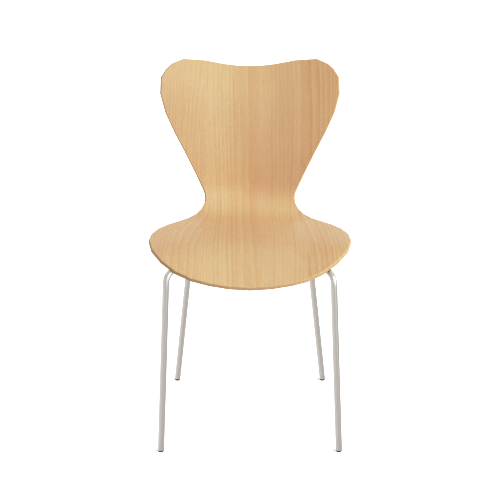

------------------------------------------------------------
추천 15순위 : 맥시멈 와이드 전신거울 거치대형 600 (내추럴)


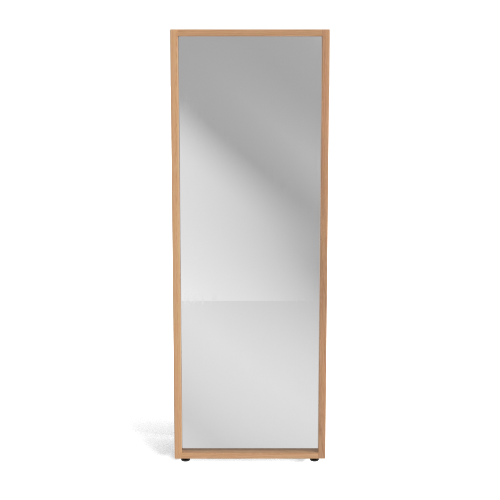

------------------------------------------------------------
추천 16순위 : Vanilla Spring no.05


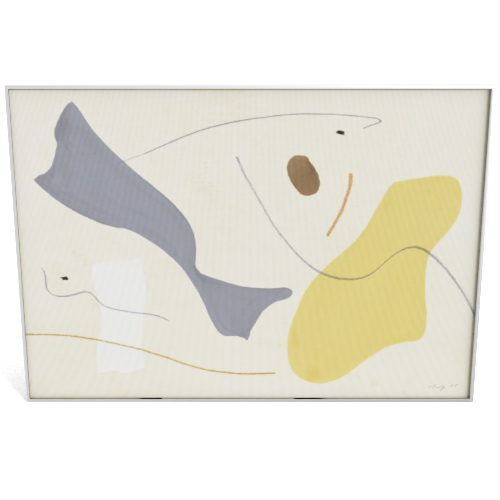

------------------------------------------------------------
추천 17순위 : 하임 원목 책상의자 (시나몬)


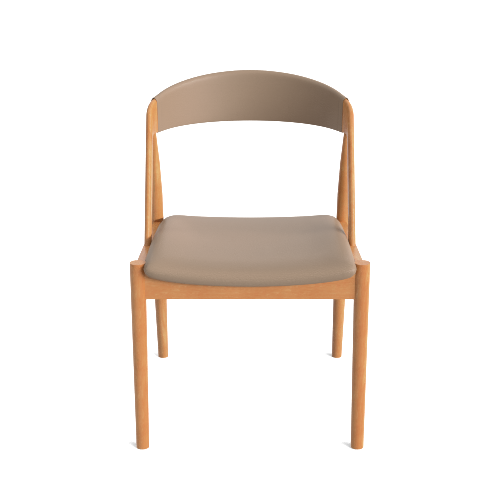

------------------------------------------------------------
추천 18순위 : 702X TABLE -SILVER- 원형테이블 1100 (화이트)


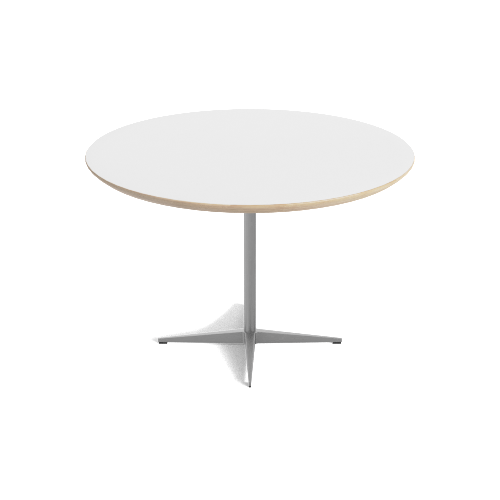

------------------------------------------------------------


In [9]:
print(item_name)
search_engine_b.search_product(item_name, topn=18)

## 모델의 다양성 평가

In [10]:
# 추천해준 결과값 dataframe
result = search_engine_b.result
#선택한 item -projectId
project_id = search_engine_b.project_id

def average(project_id,products_df, result, number):
    results = []
    for i in range(len(project_id)):
        # products_df에서 검색한 프로젝트 아이디를 찾고 프로젝트 아이디가 가지고 있는 아이템들을 list로 가져오기
        project_products_id = products_df[products_df['projectId'] == project_id[i]]['product_id'].tolist()
        #result(추천해준 제품들) 리스트 업
        result_product_id = result['product_id'].tolist()
        for j in range(len(result_product_id)):
            # 해당 제품의 프로젝트 아이디가 가지고 있는 아이템 중 추천한 아이템이 들어있는가 
            if result_product_id[j] in project_products_id:
                # 들어있으면 1
                result_product_id[j] = 1
            else:
                # 없으면 0
                result_product_id[j] = 0
        results.append(result_product_id)
        
    total = []
    for result in results:
        total.append(sum(result) / len(result))
    
    total = sorted(total, reverse=True)[:5]
    print(f'Top {number} 해당해는 비율')
    for num, i in enumerate(total):
        print(f'{num+1}선택한 프로젝트 아이템이 들어있는 비율 : {round(i, 3)}  다른 프로젝트 아이템이 들어있는 비율 : {round(1 - i, 3)}')
#     print(round(total[0]/len(total[0])))
#     print(1 - round(sum(total[0])/len(total[0])))
    # 해당 제품의 projectId (전문가 ID) 에 들어있는
    # 제품을 추천을 하지 않으면 다른 프로젝트 아이템을 추천해준 것이기에 다양성이 증가 -> 다른프로젝트 아이템이 들어있는 비율
    # 제품을 추천을 하게 되면 다양성이 감소 -> 선택한 프로젝트 아이템이 들어있는 비율
    # return f'선택한 프로젝트 아이템이 들어있는 비율 : {round(sum(result_product_id)/(len(result_product_id)-1), 3)}  다른 프로젝트 아이템이 들어있는 비율 : {round(1 - (sum(result_product_id)/(len(result_product_id)-1)), 3)}'

In [11]:
average(project_id, products_df_b, result, 5)

Top 5 해당해는 비율
1선택한 프로젝트 아이템이 들어있는 비율 : 0.5  다른 프로젝트 아이템이 들어있는 비율 : 0.5
2선택한 프로젝트 아이템이 들어있는 비율 : 0.444  다른 프로젝트 아이템이 들어있는 비율 : 0.556
3선택한 프로젝트 아이템이 들어있는 비율 : 0.167  다른 프로젝트 아이템이 들어있는 비율 : 0.833
4선택한 프로젝트 아이템이 들어있는 비율 : 0.111  다른 프로젝트 아이템이 들어있는 비율 : 0.889
5선택한 프로젝트 아이템이 들어있는 비율 : 0.111  다른 프로젝트 아이템이 들어있는 비율 : 0.889


In [12]:
len(project_id)

46

## dcg_score, ndcg_score 구현 

In [12]:
# Rank 기반 추천시스템 평가지표 
from sklearn.metrics import dcg_score, ndcg_score
# rank = [[1, 2, 3, ...]]
# score = [[ .. .. .. ]]
rank = [np.arange(1, len(result)+1).tolist()]
score = [result['similarity'].values.tolist()]

#ignore_ties -> 예측 된 값들 중복 포함 여부 
print(f'dcg_score : {dcg_score(rank, score, ignore_ties=True)}')
print(f'dcg_score 중복 포함: {dcg_score(rank, score)}')
print(f'Ndcg_score : {ndcg_score(rank, score, ignore_ties=True)}')
print(f'Ndcg_score 중복 포함: {ndcg_score(rank, score)}')

dcg_score : 49.30554914984183
dcg_score 중복 포함: 49.30995270304331
Ndcg_score : 0.6509630704914131
Ndcg_score 중복 포함: 0.6510212089882462


In [13]:
rank2 =np.arange(1, len(result)+1)
score2 = result['similarity'].values

In [14]:
def ndcg_score(ranks, scores, k=len(result)):
    # score 별로 rerank
    y_true = np.take(ranks, np.argsort(scores)[::-1][:k])
    
    # log2(idx + 2)
    # python start 0 index
    # np.logs2([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) -> rank
    discounts = np.log2(np.arange(1,len(y_true)+1))
    
    # 랭킹의 순서보다 관련성에 더 비중을 주고싶은 경우에는 식을 사용
    # default = ranks / discounts
    dcg = (2**ranks-1) / discounts
    idcg = (2**y_true-1) / discounts
    
    # 무한대 값이 나오면 0 으로 적용
    dcg[dcg == inf] = 0
    idcg[idcg == inf] = 0
    
    return np.sum(dcg) / np.sum(idcg)

ndcg_score(rank2, score2)

/var/folders/dp/q_wygj995692tmkbnkqjs3_h0000gn/T/ipykernel_18276/2985424707.py:12: RuntimeWarning: divide by zero encountered in true_divide
  dcg = (2**ranks-1) / discounts
/var/folders/dp/q_wygj995692tmkbnkqjs3_h0000gn/T/ipykernel_18276/2985424707.py:13: RuntimeWarning: divide by zero encountered in true_divide
  idcg = (2**y_true-1) / discounts


0.9972813735589305

## sparse_matrix -> 전문가 셋 카테고리 별 평균을 구해 평균보다 높은 것을 추천을 하는지 비교 

In [13]:
def sparse_matrix(products_df, result):
    # enterprisedId = B 
    if products_df['enterpriseId'][0] == 'B57D4F97C0E44A11':

        # project 마다 item별 awesome_score 를 값으로 줘서 값이 존재하면 1 존재하지않으면 0
        train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T

        #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
        # 그 평균을 np.percentile을 진행해서 mean 값들의 50%에 해당하는 값보다 크면 1 작으면 0 으로 
        # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
        train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')

        # 새로운 프레임(columns=category)
        frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                           index='category',
                                                            columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
        # 추천 해준 category 이름으로 unique 적용
        # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
        for i in result['category'].unique().tolist():
            if i in frame.columns:
                frame[i] = 1
            else:
                0
        # 예측 된 값과 추천 해준 값을 비교 
        print(classification_report(frame.iloc[0].values, train.values))
        # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
        print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
        print('')
        return  f'전문가   아이템 :{train.values}','------',f'추천해준 아이템 :{frame.iloc[0].values}'
    
    else:
        #productsId = 4 
        # project 마다 item별 awesome_score 를 값으로 줘서 값이 존재하면 1 존재하지않으면 0
        train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T

        #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
        # 그 평균을 np.percentile을 진행해서 mean 값들의 40%에 해당하는 값보다 크면 1 작으면 0 으로 
        # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 40) else 0).reset_index(drop='name_x')
        train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 40) else 0).reset_index(drop='name_x')

        # 새로운 프레임(columns=category)
        frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                           index='category',
                                                            columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
        # 추천 해준 category 이름으로 unique 적용
        # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
        for i in result['category'].unique().tolist():
            if i in frame.columns:
                frame[i] = 1
            else:
                0
        # 예측 된 값과 추천 해준 값을 비교 
        print(classification_report(train.values,frame.iloc[0].values))
        # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
        print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
        print('')
        return f'추천해준 아이템 :{frame.iloc[0].values}','------', f'전문가    아이템 :{train.values}'

In [14]:
sparse_matrix(products_df_b, result)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.67      0.67      0.67         9

    accuracy                           0.67        18
   macro avg       0.67      0.67      0.67        18
weighted avg       0.67      0.67      0.67        18

Average_Precision :  0.6111111111111112



('전문가   아이템 :[1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0]',
 '------',
 '추천해준 아이템 :[0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1]')

##  sparse_matrix 데이터 구성 설명 

In [42]:
train = products_df_b.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T
train_df = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
train_df.values

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0])

In [51]:
train.describe().T['mean']

category
가전         0.702891
드레스룸/행거    0.206444
문/창문       0.008699
반려동물       0.072409
생활/운동      0.146410
소파         0.420363
수납가구       0.405538
유아동가구      0.037246
의자/스툴      0.548518
조명         0.614678
주방싱크/욕실    0.213428
책상/테이블     0.681083
책장/선반      0.355183
침대/매트리스    0.214286
파티션/구조물    0.227273
패브릭        0.670669
홈데코        0.668096
화장대/거울     0.233644
Name: mean, dtype: float64

In [49]:
np.percentile(train.describe().T['mean'], 50)

0.22467532467532467

In [39]:
train_4 = products_df_4.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T
train_df_4 = train_4.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train_4.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
train_df_4.values

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1])

In [40]:
train_4.describe().T['mean'].sort_values(ascending=False).values

array([0.58798883, 0.36731844, 0.2150838 , 0.15642458, 0.14804469,
       0.12011173, 0.10614525, 0.08100559, 0.07821229, 0.0349162 ,
       0.02932961, 0.00418994])

In [41]:
np.percentile(train_4.describe().T['mean'].sort_values(ascending=False).values, 50)

0.11312849162011174

In [44]:
frame = pd.DataFrame(columns=products_df_b.pivot_table('awesome_score',
                                                       index='category',
                                                       columns='projectId').fillna(0).round().astype(int).T.columns,
                    index=['user']).fillna(0)
frame

category,가전,드레스룸/행거,문/창문,반려동물,생활/운동,소파,수납가구,유아동가구,의자/스툴,조명,주방싱크/욕실,책상/테이블,책장/선반,침대/매트리스,파티션/구조물,패브릭,홈데코,화장대/거울
user,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
frame_4 = pd.DataFrame(columns=products_df_4.pivot_table('awesome_score',
                                                       index='category',
                                                       columns='projectId').fillna(0).round().astype(int).T.columns,
                    index=['user']).fillna(0)
frame_4

category,Appliances,Bathroom,Bedroom,Chairs,Construction,Décor,Kitchen,Lighting,Outdoor,Sofas,Storage,Tables
user,0,0,0,0,0,0,0,0,0,0,0,0


In [129]:
for i in result['category'].unique().tolist():
    if i in frame.columns:
        frame[i] = 1
    else:
        0

In [137]:
frame.iloc[0].values

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], dtype=int64)

In [131]:
result['category'].unique().tolist()

['조명', '패브릭', '책상/테이블', '책장/선반', '가전', '화장대/거울', nan, '파티션/구조물', '주방싱크/욕실']

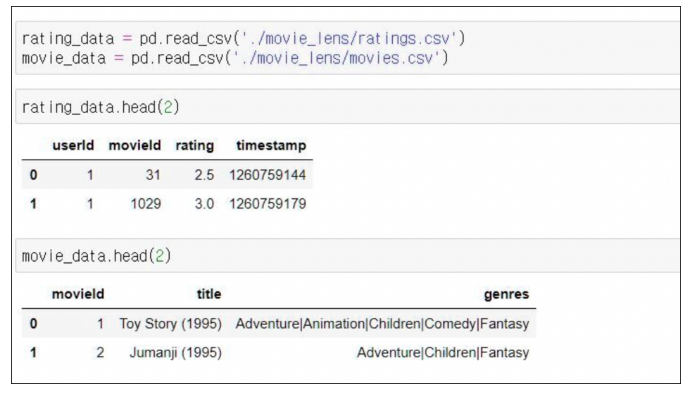

In [21]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('img.png', cv2.IMREAD_COLOR)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.show()
# 아이템기반 협업 필터링을 하기 위한 데이터 

In [15]:
result = search_engine_b.result
project_id = search_engine_b.project_id

def average(result, project_id,products_df, number):
    results = []
    for i in range(len(project_id)):
        # products_df에서 검색한 프로젝트 아이디를 찾고 프로젝트 아이디가 가지고 있는 아이템들을 list로 가져오기
        project_products_id = products_df[products_df['projectId'] == project_id[i]]['product_id'].tolist()
        #result(추천해준 제품들) 리스트 업
        result_product_id = result['product_id'].tolist()
        for j in range(len(result_product_id)):
            # 해당 제품의 프로젝트 아이디가 가지고 있는 아이템 중 추천한 아이템이 들어있는가 
            if result_product_id[j] in project_products_id:
                # 들어있으면 1
                result_product_id[j] = 1
            else:
                # 없으면 0
                result_product_id[j] = 0
        results.append(result_product_id)

    total = []
    for res in results:
        total.append(sum(res) / len(res))
    
    total = sorted(total, reverse=True)[:5]
    print(f'Top {number} 해당해는 비율')
    for num, i in enumerate(total):
        print(f'{num+1}선택한 프로젝트 아이템이 들어있는 비율 : {round(i, 3)}  다른 프로젝트 아이템이 들어있는 비율 : {round(1 - i, 3)}')
        
    
# def sparse_matrix(products_df, result):
    # project 마다 item별 awesome_score 를 값으로 줘서 값이 존재하면 1 존재하지않으면 0
    if products_df['enterpriseId'][0] == 'B57D4F97C0E44A11':
        train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T

        #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
        # 그 평균을 np.percentile을 진행해서 mean 값들의 70%에 해당하는 값보다 크면 1 작으면 0 으로 
        # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
        train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')

        # 새로운 프레임(columns=category)
        frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                           index='category',
                                                            columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
        # 추천 해준 category 이름으로 unique 적용
        # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
        for i in result['category'].unique().tolist():
            if i in frame.columns:
                frame[i] = 1
            else:
                0
        print()
        # 예측 된 값과 추천 해준 값을 비교 
        print('전문가 셋 데이터 비교평가')
        
        print(classification_report(frame.iloc[0].values, train.values))
        # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
        print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
        print('')
        return f'추천해준 아이템 :{frame.iloc[0].values}', '------',f'전문가   아이템 :{train.values}'
    else:
        train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T

        #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
        # 그 평균을 np.percentile을 진행해서 mean 값들의 70%에 해당하는 값보다 크면 1 작으면 0 으로 
        # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
        train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')

        # 새로운 프레임(columns=category)
        frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                           index='category',
                                                            columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
        # 추천 해준 category 이름으로 unique 적용
        # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
        for i in result['category'].unique().tolist():
            if i in frame.columns:
                frame[i] = 1
            else:
                0
        print()
        # 예측 된 값과 추천 해준 값을 비교 
        print('전문가 셋 데이터 비교평가')
        # 예측 된 값과 추천 해준 값을 비교 
        print(classification_report(frame.iloc[0].values, train.values))
        # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
        print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
        print('')
        return f'추천해준 아이템 :{frame.iloc[0].values}', '------',f'전문가   아이템 :{train.values}'
        
average(result, project_id, products_df_b, 5)

Top 5 해당해는 비율
1선택한 프로젝트 아이템이 들어있는 비율 : 0.5  다른 프로젝트 아이템이 들어있는 비율 : 0.5
2선택한 프로젝트 아이템이 들어있는 비율 : 0.444  다른 프로젝트 아이템이 들어있는 비율 : 0.556
3선택한 프로젝트 아이템이 들어있는 비율 : 0.167  다른 프로젝트 아이템이 들어있는 비율 : 0.833
4선택한 프로젝트 아이템이 들어있는 비율 : 0.111  다른 프로젝트 아이템이 들어있는 비율 : 0.889
5선택한 프로젝트 아이템이 들어있는 비율 : 0.111  다른 프로젝트 아이템이 들어있는 비율 : 0.889

전문가 셋 데이터 비교평가
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.67      0.67      0.67         9

    accuracy                           0.67        18
   macro avg       0.67      0.67      0.67        18
weighted avg       0.67      0.67      0.67        18

Average_Precision :  0.6111111111111112



('추천해준 아이템 :[0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1]',
 '------',
 '전문가   아이템 :[1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0]')